In [20]:
#bibliotecas básicas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
import yfinance as yf

#estatística
from numpy import percentile
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from scipy import signal
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from sklearn.inspection import permutation_importance

#análise
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

#modelo
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor
import xgboost as xgb

#escolha do modelo
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

#resultados
from sklearn.metrics import mean_squared_error

#erros
import pandas as pd
pd.options.mode.chained_assignment = None
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

In [21]:
train = pd.read_csv("train.csv", parse_dates= ['DT_COMPTC'])
test = pd.read_csv("full_dataset.csv", parse_dates= ['DT_COMPTC'])
test['Fluxo'] = test['Fluxo']/1000000

additive = pd.read_csv("additive.csv")
submission = pd.read_csv("sample_submission.csv")

dateparse = lambda x: datetime.strptime(x, '%d/%m/%Y')

desemprego = pd.read_csv("features\\desemprego.csv", sep= ';', decimal= ',', parse_dates= ['DateTime'])
ipca = pd.read_csv("features\\ipca.csv", sep= ';', decimal= ',', parse_dates= ['DateTime'], usecols= [0,2])
pib = pd.read_csv("features\\pib.csv", sep= ';', decimal= ',', parse_dates= ['Data'])
fedfunds = pd.read_csv("features\\fedfunds.csv", sep= ',', decimal= '.', parse_dates= ['DATE'])
selic = pd.read_csv("features\\selic.csv",sep= ';', decimal= '.', parse_dates=['Date'], date_parser= dateparse)
iee = pd.read_csv("features\\iee.csv",sep= ',', decimal= '.', thousands= ',', parse_dates=['Date'], infer_datetime_format=True, usecols=[0,1])
ifnc = pd.read_csv("features\\ifnc.csv",sep= ',', decimal= '.', thousands= ',', parse_dates=['Date'], infer_datetime_format=True, usecols=[0,1])
imat = pd.read_csv("features\\imat.csv",sep= ',', decimal= '.', thousands= ',', parse_dates=['Date'], infer_datetime_format=True, usecols=[0,1])
imob = pd.read_csv("features\\imob.csv",sep= ',', decimal= '.', thousands= ',', parse_dates=['Date'], infer_datetime_format=True, usecols=[0,1])
externo = pd.read_csv("features\\externo.csv",sep= ',', decimal= '.', thousands= ',', parse_dates=['Index'], infer_datetime_format=True)
dji = yf.Ticker("^DJI").history(period="max")[['Volume', 'Close']]


selic.rename({'11 - Interest rate - Selic - % p.d.': 'SELIC'}, axis=1, inplace= True)
iee.rename({'Price': 'IEE'}, axis=1, inplace= True)
ifnc.rename({'Price': 'IFNC'}, axis=1, inplace= True)
imat.rename({'Price': 'IMAT'}, axis=1, inplace= True)
imob.rename({'Price': 'IMOB'}, axis=1, inplace= True)
dji.rename({'Volume': 'DJI.Volume', 'Close': 'DJI.Close'}, axis=1, inplace= True)

In [22]:
def juntar(df1, df2):
        df1 = pd.merge(
            df2,
            df1,
            left_on=[df2[df2.columns[0]].dt.year, df2[df2.columns[0]].dt.month],
            right_on=[df1["DT_COMPTC"].dt.year, df1["DT_COMPTC"].dt.month],
            how="right",
            ).drop(["key_0", "key_1","DateTime", "Data","Mês"], axis=1, errors = 'ignore')

        return df1

In [23]:
#juntando os dataframes

#taxa de desemprego
train = juntar(train, desemprego)
test = juntar(test, desemprego)

#IPCA
train = juntar(train, ipca)
test = juntar(test, ipca)

#PIB
train = juntar(train, pib)
test = juntar(test, pib)

#Fed Funds Rate
train = pd.merge(train, fedfunds, left_on= 'DT_COMPTC', right_on='DATE', how='left').drop('DATE', axis=1).fillna(method='ffill')
test = pd.merge(test, fedfunds, left_on= 'DT_COMPTC', right_on='DATE', how='left').drop('DATE', axis=1).fillna(method='ffill')

#SELIC
train = pd.merge(train, selic, left_on= 'DT_COMPTC', right_on='Date', how='left').drop('Date', axis=1).fillna(method='ffill')
test = pd.merge(test, selic, left_on= 'DT_COMPTC', right_on='Date', how='left').drop('Date', axis=1).fillna(method='ffill')

#IEE
train = pd.merge(train, iee, left_on= 'DT_COMPTC', right_on='Date', how='left').drop('Date', axis=1).fillna(method='ffill')
test = pd.merge(test, iee, left_on= 'DT_COMPTC', right_on='Date', how='left').drop('Date', axis=1).fillna(method='ffill')

#IFNC
train = pd.merge(train, ifnc, left_on= 'DT_COMPTC', right_on='Date', how='left').drop('Date', axis=1).fillna(method='ffill')
test = pd.merge(test, ifnc, left_on= 'DT_COMPTC', right_on='Date', how='left').drop('Date', axis=1).fillna(method='ffill')

#IMAT
train = pd.merge(train, imat, left_on= 'DT_COMPTC', right_on='Date', how='left').drop('Date', axis=1).fillna(method='ffill')
test = pd.merge(test, imat, left_on= 'DT_COMPTC', right_on='Date', how='left').drop('Date', axis=1).fillna(method='ffill')

#IMOB
train = pd.merge(train, imob, left_on= 'DT_COMPTC', right_on='Date', how='left').drop('Date', axis=1).fillna(method='ffill')
test = pd.merge(test, imob, left_on= 'DT_COMPTC', right_on='Date', how='left').drop('Date', axis=1).fillna(method='ffill')

#Mercado externo
train = pd.merge(train, externo, left_on= 'DT_COMPTC', right_on='Index', how='left').drop('Index', axis=1).fillna(method='ffill')
test = pd.merge(test, externo, left_on= 'DT_COMPTC', right_on='Index', how='left').drop('Index', axis=1).fillna(method='ffill')

#Dow Jones Industrial Average
train = pd.merge(train, dji, left_on= 'DT_COMPTC', right_on=dji.index, how='left').fillna(method='ffill')
test = pd.merge(test, dji, left_on= 'DT_COMPTC', right_on=dji.index, how='left').fillna(method='ffill')

In [24]:
train.fillna(method='bfill', inplace=True)

train

,PIB mensal,IPCA ocorrido,Taxa de Desocupação,DT_COMPTC,IBOV,Dol,NDX,SPX,Fluxo,DFF,...,N225.Volume,HSI.Close,HSI.Volume,EUR.Close,JPY.Close,AUD.Close,GBP.Close,CNY.Close,DJI.Volume,DJI.Close
0,161645.2,5.28,7.1,2005-01-03,25722.0,2.6759,1603.51,1202.08,20.621,2.31,...,41000000.0,14237.419922,1.455630e+08,0.742390,102.739998,1.303600,0.52504,8.266501,270620000.0,10729.429688
1,161645.2,5.28,7.1,2005-01-04,24848.0,2.7190,1571.83,1188.05,3.777,2.25,...,41000000.0,14045.900391,3.974982e+08,0.752900,104.339996,1.303600,0.53090,8.266501,293280000.0,10630.780273
2,161645.2,5.28,7.1,2005-01-05,24691.8,2.7140,1563.76,1183.74,2.692,2.25,...,77500000.0,13764.360352,5.302006e+08,0.753010,103.930000,1.303600,0.53036,8.266501,263550000.0,10597.830078
3,161645.2,5.28,7.1,2005-01-06,24366.9,2.7218,1557.52,1187.89,14.528,2.25,...,87100000.0,13712.040039,4.187616e+08,0.758550,104.889999,1.303600,0.53291,8.266501,232850000.0,10622.879883
4,161645.2,5.28,7.1,2005-01-07,24747.2,2.7120,1564.81,1186.19,-2.328,2.24,...,72300000.0,13574.860352,5.712064e+08,0.765640,104.889999,1.303600,0.53439,8.266501,283770000.0,10603.959961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4116,712134.2,8.06,14.7,2021-05-13,120705.9,5.3087,13109.15,4112.50,252.986,0.06,...,80500000.0,27718.669922,2.167382e+09,0.827917,109.664001,1.293276,0.71105,6.455200,350820000.0,34021.449219
4117,712134.2,8.06,14.7,2021-05-14,121880.8,5.2728,13393.12,4173.85,286.348,0.06,...,73500000.0,28027.570313,1.880805e+09,0.828000,109.515999,1.294297,0.71170,6.450900,303230000.0,34382.128906
4118,712134.2,8.06,14.7,2021-05-17,122937.9,5.2751,13312.91,4163.29,-127.213,0.06,...,63900000.0,28194.089844,1.857028e+09,0.823020,109.412003,1.285560,0.70913,6.436100,291910000.0,34327.789062
4119,712134.2,8.06,14.7,2021-05-18,122980.0,5.2613,13217.68,4127.83,378.025,0.06,...,74700000.0,28593.810547,2.065990e+09,0.822580,109.241997,1.286389,0.70678,6.438200,289590000.0,34060.660156


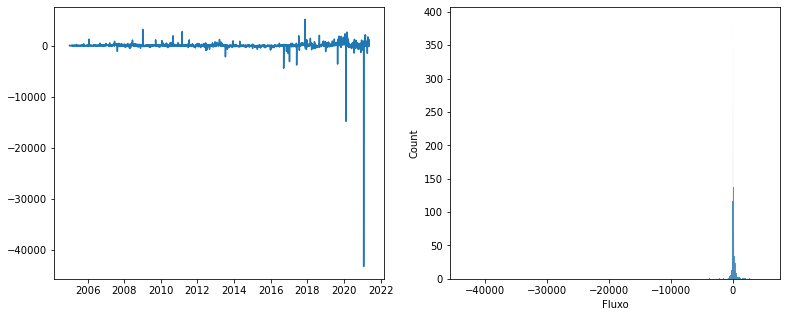

In [25]:
# análise da serie temporal
train = train.set_index(pd.to_datetime(train['DT_COMPTC']))
test = test.set_index(pd.to_datetime(test['DT_COMPTC']))

plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.plot(train['Fluxo'])
plt.subplot(1,2,2)
sns.histplot(train['Fluxo'])
plt.show()

In [26]:
# espaço interquartil
fluxo = train['Fluxo']

q25, q75 = percentile(fluxo, 25), percentile(fluxo, 75)
iqr = q75 - q25

# separando os outliers
corte = iqr * 5
lower, upper = q25 - corte, q75 + corte

outliers = [x for x in fluxo if x < lower or x > upper]

#removendo outliers
fluxo = [x for x in fluxo if x > lower and x < upper]

print('Outliers identificados: %d' % len(outliers))
print('Observações não-outliers: %d' % len(fluxo))

train_og = train.copy()

train['Fluxo'] = np.where(
    train['Fluxo'] > upper,
    upper,
    np.where(
        train['Fluxo'] < lower,
        lower,
        train['Fluxo']
    )
)

Outliers identificados: 116
Observações não-outliers: 4005


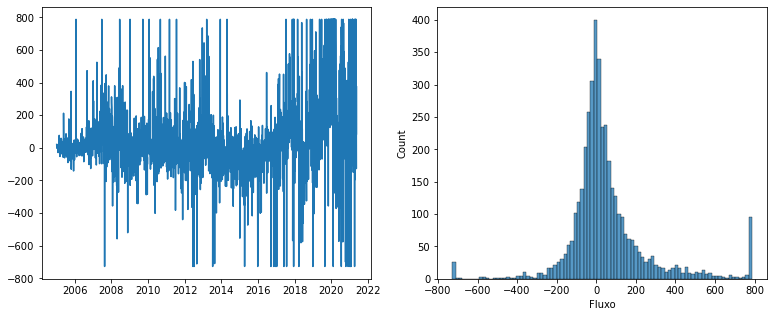

In [27]:
plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.plot(train['Fluxo'])
plt.subplot(1,2,2)
sns.histplot(train['Fluxo'])
plt.show()

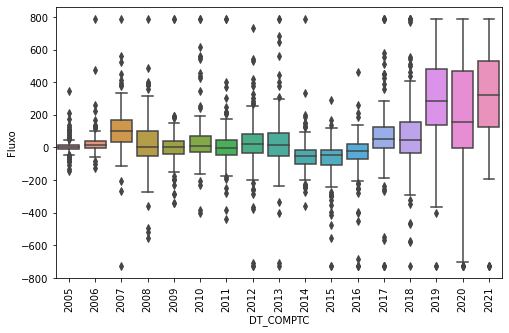

In [28]:
# Análise da tendência por boxplot
plt.figure(figsize=(8,5))
ax = sns.boxplot(data = train, x=train.index.year,y='Fluxo')
for item in ax.get_xticklabels():
    item.set_rotation(90)


plt.show()

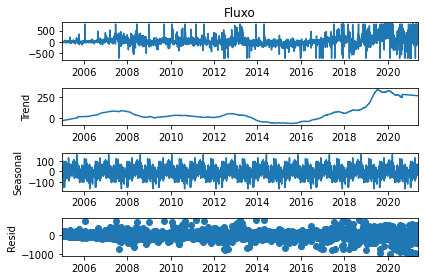

In [29]:
# Análise da tendência e sazonalidade por decomposição aditiva
result_add = seasonal_decompose(train['Fluxo'], model='additive', extrapolate_trend='freq', period = 365)

# Plot
result_add.plot()
plt.show()

In [30]:
# correlação
train = train.loc['2012':'2021']

train.corr(method='pearson')

,PIB mensal,IPCA ocorrido,Taxa de Desocupação,IBOV,Dol,NDX,SPX,Fluxo,DFF,SELIC,...,N225.Volume,HSI.Close,HSI.Volume,EUR.Close,JPY.Close,AUD.Close,GBP.Close,CNY.Close,DJI.Volume,DJI.Close
PIB mensal,1.000000,-0.392905,0.857255,0.820358,0.883976,0.922027,0.963831,0.380623,0.489477,-0.561744,...,-0.614725,0.701714,0.245307,0.519580,0.524254,0.785270,0.734797,0.664660,0.645356,0.959313
IPCA ocorrido,-0.392905,1.000000,-0.452607,-0.621615,-0.254843,-0.442618,-0.440129,-0.323385,-0.497691,0.725035,...,0.494834,-0.520821,-0.076294,0.035098,0.164893,-0.182232,-0.509476,-0.499783,-0.640491,-0.511346
Taxa de Desocupação,0.857255,-0.452607,1.000000,0.717995,0.829127,0.827361,0.848680,0.291605,0.465064,-0.464165,...,-0.562067,0.594007,0.238304,0.615398,0.397947,0.743038,0.873596,0.767801,0.714049,0.848224
IBOV,0.820358,-0.621615,0.717995,1.000000,0.713654,0.884323,0.877561,0.522106,0.505498,-0.819638,...,-0.626486,0.680282,0.208124,0.256164,0.085582,0.496792,0.621351,0.613662,0.654930,0.901640
Dol,0.883976,-0.254843,0.829127,0.713654,1.000000,0.916278,0.893124,0.287643,0.241507,-0.539602,...,-0.518193,0.471554,0.274236,0.589082,0.483189,0.823168,0.686470,0.664973,0.632446,0.850019
NDX,0.922027,-0.442618,0.827361,0.884323,0.916278,1.000000,0.977861,0.376867,0.289001,-0.723719,...,-0.598823,0.641227,0.297749,0.373184,0.333651,0.647512,0.632838,0.584915,0.674578,0.949851
SPX,0.963831,-0.440129,0.848680,0.877561,0.893124,0.977861,1.000000,0.389518,0.415923,-0.649018,...,-0.624761,0.732921,0.274136,0.440864,0.456072,0.716105,0.681787,0.617630,0.661849,0.988515
Fluxo,0.380623,-0.323385,0.291605,0.522106,0.287643,0.376867,0.389518,1.000000,0.306368,-0.419531,...,-0.241858,0.302149,0.082031,0.139908,0.001729,0.243689,0.310079,0.357900,0.331255,0.417184
DFF,0.489477,-0.497691,0.465064,0.505498,0.241507,0.289001,0.415923,0.306368,1.000000,-0.271332,...,-0.488163,0.624186,-0.027636,0.382162,0.270502,0.497484,0.605979,0.571474,0.402079,0.534374
SELIC,-0.561744,0.725035,-0.464165,-0.819638,-0.539602,-0.723719,-0.649018,-0.419531,-0.271332,1.000000,...,0.428461,-0.492948,-0.201251,0.117865,0.205847,-0.187908,-0.362487,-0.369034,-0.634238,-0.670414


In [31]:
y, X = train['Fluxo'], train.drop(['Fluxo','DT_COMPTC'], axis=1)

#Seleção de features por testes estatisticos univariáveis (Select K Best)

skb = SelectKBest(score_func=f_regression, k=5)

skb = skb.fit(X,y)

dfscores = pd.DataFrame(skb.scores_)
dfcolumns = pd.DataFrame(X.columns)

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  
print(featureScores.nlargest(10,'Score'))  

       Feature        Score
12        IMOB  1069.078628
3         IBOV   885.533439
10        IFNC   802.729032
9          IEE   734.972445
8        SELIC   504.739561
27   DJI.Close   497.920867
11        IMAT   441.226331
6          SPX   422.650061
0   PIB mensal   400.334353
5          NDX   391.171594


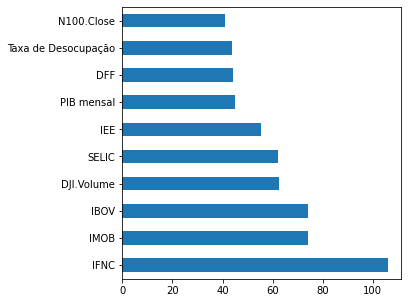

In [32]:
#Meta estimador de features por árvores de decisão randomizadas (extra-trees)

model = ExtraTreesRegressor(n_estimators=200).fit(X,y)

perm = permutation_importance(model, X, y, scoring= 'neg_root_mean_squared_error')

feat_importances = pd.Series(perm.importances_mean, index=X.columns)

plt.figure(figsize=(5,5))
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [33]:
# Cortando a time series

train = train.loc['2016':'2018']
test = test.loc['2021-05-19':'2022-07-26']

features = ['IFNC', 'IEE', 'IMOB', 'Dol', 'SPX', 'NDX']

y_train, X_train = train['Fluxo'], train[features]

y_test, X_test = test['Fluxo'], test[features]

y, X = train['Fluxo'], train[features]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, shuffle= False)

# normalização dos dados das variáveis 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.fit_transform(X_test)

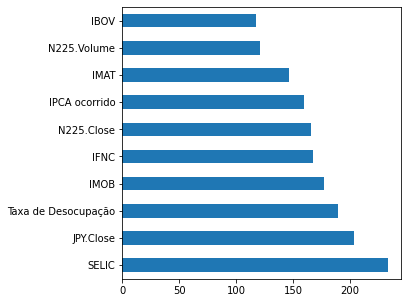

In [34]:
#Meta estimador de features por árvores de decisão randomizadas (extra-trees)

model = ExtraTreesRegressor().fit(test.drop(['Fluxo','DT_COMPTC','CAPTC_DIA', 'RESG_DIA','Unnamed: 0'], axis=1),test['Fluxo'])

perm = permutation_importance(model, test.drop(['Fluxo','DT_COMPTC','CAPTC_DIA', 'RESG_DIA','Unnamed: 0'], axis=1), test['Fluxo'], scoring= 'neg_root_mean_squared_error', random_state= 1)

feat_importances = pd.Series(perm.importances_mean, index=test.drop(['Fluxo','DT_COMPTC','CAPTC_DIA', 'RESG_DIA','Unnamed: 0'], axis=1).columns)

plt.figure(figsize=(5,5))
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [35]:
# ensemble do modelo por stacking
@ignore_warnings(category=ConvergenceWarning)
def get_stacking():
	# modelos base
	level0 = list()
	level0.append(('KNeighbors', KNeighborsRegressor()))
	level0.append(('SVR', SVR(kernel='poly')))
	level0.append(('XGBoost', xgb.XGBRegressor()))
	level0.append(('Decision', DecisionTreeRegressor()))
	level0.append(('GradientBoosting', GradientBoostingRegressor()))
	# modelo meta learner
	level1 = MLPRegressor(shuffle=False, max_iter=10000)
	model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
	return model
 
# modelos para avaliar
def get_models():
	models = dict()
	models['SVR'] = SVR(kernel='poly')
	models['KNeighbors'] = KNeighborsRegressor()
	models['DecisionTree'] = DecisionTreeRegressor()
	models['XGBoost'] = xgb.XGBRegressor()
	models['MLP'] = MLPRegressor(shuffle=False, max_iter=5000)
	models['GradientBoosting'] = GradientBoostingRegressor()
	models['Stacking'] = get_stacking()
	return models
 
# avaliação dos modelos por cross-validation
def evaluate_model(model, X, y):
	cv = KFold(n_splits=5)
	scores = cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
	return scores
 
# models = get_models()

# results, names = list(), list()
# for name, model in models.items():
# 	scores = evaluate_model(model, X_teste_real_norm, y_teste_real)
# 	results.append(scores)
# 	names.append(name)
# 	print('%s %.3f (%.3f)' % (name, -np.mean(scores), np.std(scores)))

# # plot 
# plt.boxplot(results, labels=names, showmeans=True)
# plt.show()

In [36]:
params = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive','invscaling'],
}

model = MLPRegressor(shuffle=False)

@ignore_warnings(category=ConvergenceWarning)
def gridsearch(model, params, X, y):
    grid = GridSearchCV(model,
                        params,
                        scoring= 'neg_root_mean_squared_error',
                        cv = KFold(n_splits=5),
                        error_score=np.nan,
                        n_jobs=-1,
                        verbose=2).fit(X_teste_real_norm, y_teste_real)
    return grid

# gridsearch(model, params, X_train_norm, y_train).best_params_

In [37]:
mlp = MLPRegressor(shuffle = False,
                    activation='relu',
                    alpha = 0.05,
                    hidden_layer_sizes= (100,),
                    learning_rate='adaptive',
                    solver = 'sgd',
                    max_iter= 10000,
                    random_state=98).fit(X_train_norm, y_train)

# mlp = get_stacking().fit(X_train_norm, y_train)

# mlp = GradientBoostingRegressor(n_estimators = 100, learning_rate=0.1,random_state= 1).fit(X_train_norm, y_train)

y_pred = mlp.predict(X_test_norm)

c:\Users\vlaub\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [38]:
X_teste_real = test.loc['2021-05-19':'2022-07-26'][features]
y_teste_real = test.loc['2021-05-19':'2022-07-26']['Fluxo']
X_teste_real_norm = scaler.fit_transform(X_teste_real)

y_pred_real = mlp.predict(X_teste_real_norm)

In [39]:
comp = pd.read_csv("forecast2.0.csv")

rmse_treino = mean_squared_error(y_test, y_pred, squared=False)
rmse_teste = mean_squared_error(y_teste_real, y_pred_real, squared=False)
rmse_comp = mean_squared_error(y_teste_real, comp['Fluxo'], squared=False)


print('RMSE do treinamento : %.3f' % (rmse_treino))
print('RMSE do teste : %.3f' % (rmse_teste))
print('RMSE da competição : %.3f' % (rmse_comp))

RMSE do treinamento : 658.082
RMSE do teste : 658.082
RMSE da competição : 686.363


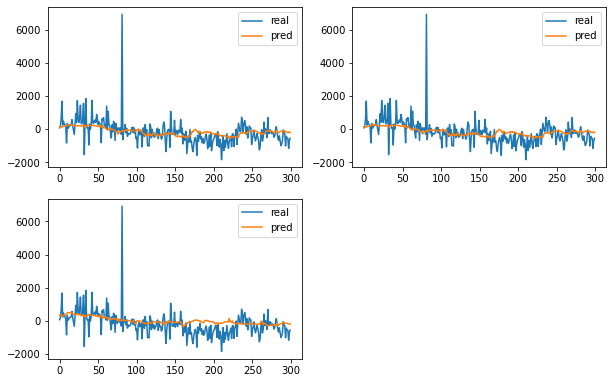

In [40]:
plt.figure(figsize= (10,10))

plt.subplot(3,2,1)
plt.plot(y_test.values, label = "real")
plt.plot(y_pred, label = "pred")
plt.legend()

plt.subplot(3,2,2)
plt.plot(y_teste_real.values, label = "real")
plt.plot(y_pred_real, label = "pred")
plt.legend()

plt.subplot(3,2,3)
plt.plot(y_teste_real.values, label = "real")
plt.plot(comp['Fluxo'], label = "pred")
plt.legend()

plt.show()

In [41]:
# y_forecast = pd.DataFrame(y_forecast, index=test['DT_COMPTC'], columns=['Fluxo'])

# y_forecast.to_csv('forecast6.0.csv', encoding='utf-8')

# y_forecast